In [1]:
import pandas as pd
import numpy as np
import requests
import re
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '8'
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from scipy.stats import ttest_ind, mannwhitneyu, levene
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error,root_mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from nltk.corpus import stopwords

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\invil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
def download_document(file_name, document_url):
   if os.path.exists(file_name):
       pass
   else:
       response = requests.get(document_url)
       if response.status_code == 200:
           with open(file_name, 'wb') as f:
               f.write(response.content)
       else:
           print(f'Failed to download the document. Status code: {response.status_code}')

In [4]:
document_url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv'
file_name = 'ikea.csv'
download_document(file_name,document_url)
df = pd.read_csv(file_name)

In [5]:
df.drop(['link'],axis=1,inplace=True)

**Прибираю link, бо вважаю його несуттєвим**

In [6]:
df.describe()

,Unnamed: 0,item_id,price,depth,height,width
count,3694.000000,3.694000e+03,3694.000000,2231.000000,2706.000000,3105.000000
mean,1846.500000,4.863240e+07,1078.208419,54.379202,101.679970,104.470853
std,1066.510275,2.888709e+07,1374.652494,29.958351,61.097585,71.133771
min,0.000000,5.848700e+04,3.000000,1.000000,1.000000,1.000000
25%,923.250000,2.039057e+07,180.900000,38.000000,67.000000,60.000000
50%,1846.500000,4.928808e+07,544.700000,47.000000,83.000000,80.000000
75%,2769.750000,7.040357e+07,1429.500000,60.000000,124.000000,140.000000
max,3693.000000,9.993262e+07,9585.000000,257.000000,700.000000,420.000000


In [7]:
print('Загальна кількість:',df['item_id'].count())
print('Кількість унікальних:',df['item_id'].nunique())

Загальна кількість: 3694
Кількість унікальних: 2962


In [8]:
df['designer'] = df['designer'].apply(
    lambda x: '/'.join(sorted([d.strip() for d in x.split('/')]))
)

**Правильно записуємо всіх дизайнерів**

In [9]:
duplicates = df[df.duplicated(subset=['item_id','price','depth','height','width'], keep=False)]
duplicates

,Unnamed: 0,item_id,name,category,price,old_price,sellable_online,other_colors,short_description,designer,depth,height,width
0,0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0
1,1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0
3,3,80155205,STIG,Bar furniture,69.0,No old price,True,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0
4,4,30180504,NORBERG,Bar furniture,225.0,No old price,True,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0
5,5,10122647,INGOLF,Bar furniture,345.0,No old price,True,No,"Bar stool with backrest, 63 cm",Carina Bengs,45.0,91.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3548,3548,90421911,BRYGGJA,Wardrobes,597.0,SR 995,True,No,"Storage unit, 120x173 cm",Ola Wihlborg,43.0,173.0,120.0
3572,3572,9157261,ELVARLI,Wardrobes,440.0,SR 540,True,No,"1 section, 52x36x222-350 cm",Ehlén Johansson,35.0,NaN,51.0
3628,3628,99188003,ELVARLI,Wardrobes,2377.0,"SR 3,025",True,No,"4 sections, 262x36x222-350 cm",Ehlén Johansson,35.0,NaN,261.0
3676,3676,59315159,ELVARLI,Wardrobes,2397.0,"SR 2,945",True,No,"3 sections, 258x51x222-350 cm",Ehlén Johansson,51.0,NaN,258.0


In [10]:
df.drop_duplicates(subset=['item_id','price','depth','height','width'], inplace=True)

**Прибираємо дублікати по цим колонкам**

In [11]:
df['old_price'] = (
    df['old_price']
    .str.replace('SR', '', case=False)
    .str.replace(',', '')                  
    .str.strip()                         
    .replace('No old price', np.nan)      
)
df['old_price'] = pd.to_numeric(df['old_price'], errors='coerce').astype('float64')  
df[df['old_price'].notna()].head()

,Unnamed: 0,item_id,name,category,price,old_price,sellable_online,other_colors,short_description,designer,depth,height,width
9,9,69304221,EKEDALEN / EKEDALEN,Bar furniture,2176.0,2375.0,True,No,Bar table and 4 bar stools,Ehlén Johansson,NaN,NaN,NaN
13,13,50420329,FREKVENS,Bar furniture,177.0,295.0,True,No,"Bar stool with backrest, in/outdoor, ...",Nicholai Wiig Hansen,53.0,104.0,43.0
17,17,50363649,KULLABERG,Bar furniture,140.0,175.0,True,Yes,Stool,Sarah Fager,36.0,NaN,36.0
23,23,90400517,EKEDALEN,Bar furniture,796.0,995.0,True,No,"Bar table, 120x80 cm",Ehlén Johansson,NaN,105.0,80.0
26,26,40400529,EKEDALEN,Bar furniture,796.0,995.0,True,No,"Bar table, 120x80 cm",Ehlén Johansson,NaN,105.0,80.0


In [12]:
df['final_price'] = df.apply(
    lambda row: row['old_price'] if pd.notna(row['old_price']) and row['old_price'] > row['price'] else row['price'],
    axis=1
)
df[['price', 'old_price', 'final_price']].head(10)

,price,old_price,final_price
0,265.0,NaN,265.0
1,995.0,NaN,995.0
2,2095.0,NaN,2095.0
3,69.0,NaN,69.0
4,225.0,NaN,225.0
5,345.0,NaN,345.0
6,129.0,NaN,129.0
7,195.0,NaN,195.0
8,129.0,NaN,129.0
9,2176.0,2375.0,2375.0


**Змінюю ціну за наступною логікою, якщо стара ціна > поточної то замінюємо її. Це зроблено, щоб зменшити вірогідність того що теперішня ціна - це ціна зі знижкою.**

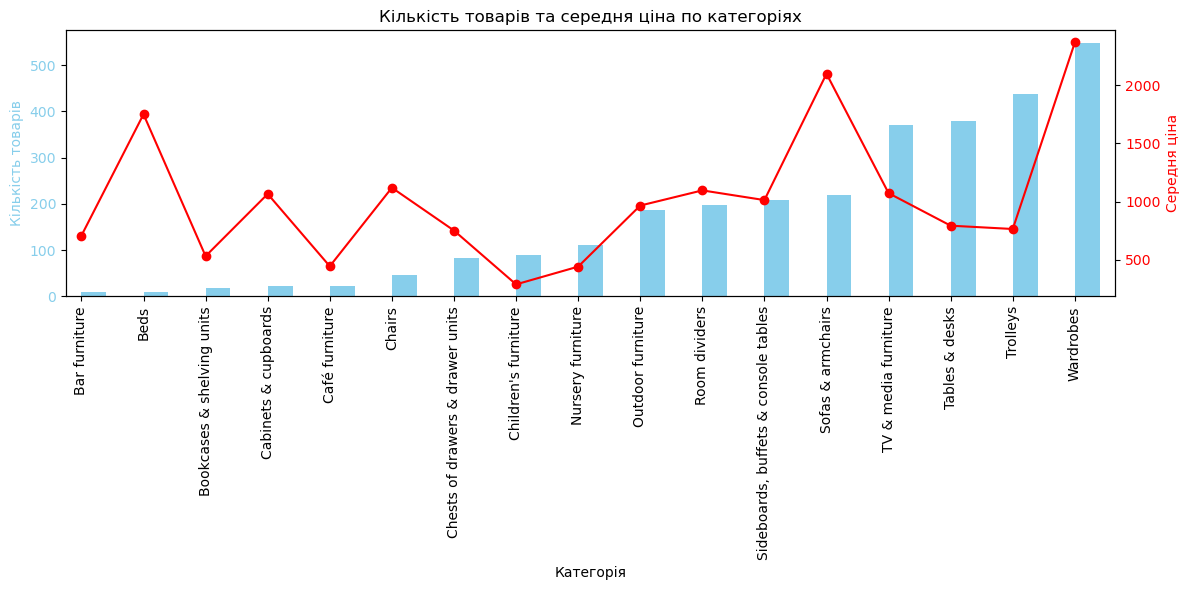

In [13]:
category_counts = df.groupby('category')['item_id'].count().sort_values(ascending=True)
category_avg_price = df.groupby('category')['final_price'].mean()
fig, ax1 = plt.subplots(figsize=(12, 6))

category_counts.plot(kind='bar', color='skyblue', ax=ax1, position=0, width=0.4)
ax1.set_ylabel('Кількість товарів', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xlabel('Категорія')

ax2 = ax1.twinx()

category_avg_price.plot(kind='line', color='red', marker='o', ax=ax2)
ax2.set_ylabel('Середня ціна', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Кількість товарів та середня ціна по категоріях')
plt.tight_layout()
plt.show()

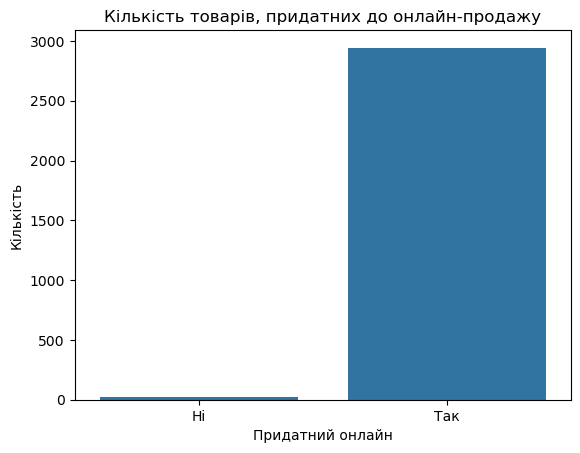

In [14]:
online_counts = df['sellable_online'].value_counts()

sns.barplot(x=online_counts.index, y=online_counts.values)
plt.title('Кількість товарів, придатних до онлайн-продажу')
plt.xlabel('Придатний онлайн')
plt.ylabel('Кількість')
plt.xticks([0, 1], ['Ні', 'Так'])  # 0 → False, 1 → True
plt.show()

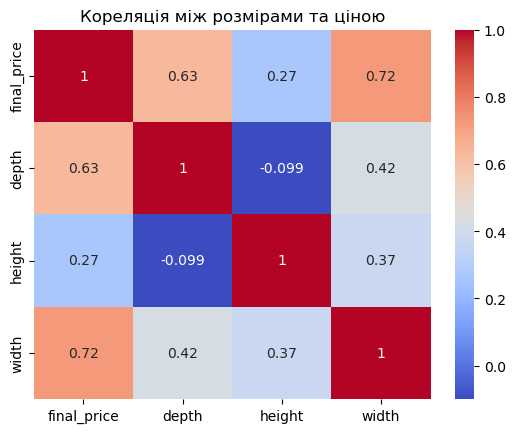

In [15]:
size_price_cols = ['final_price', 'depth', 'height', 'width']
corr_matrix = df[size_price_cols].corr()


sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Кореляція між розмірами та ціною')
plt.show()

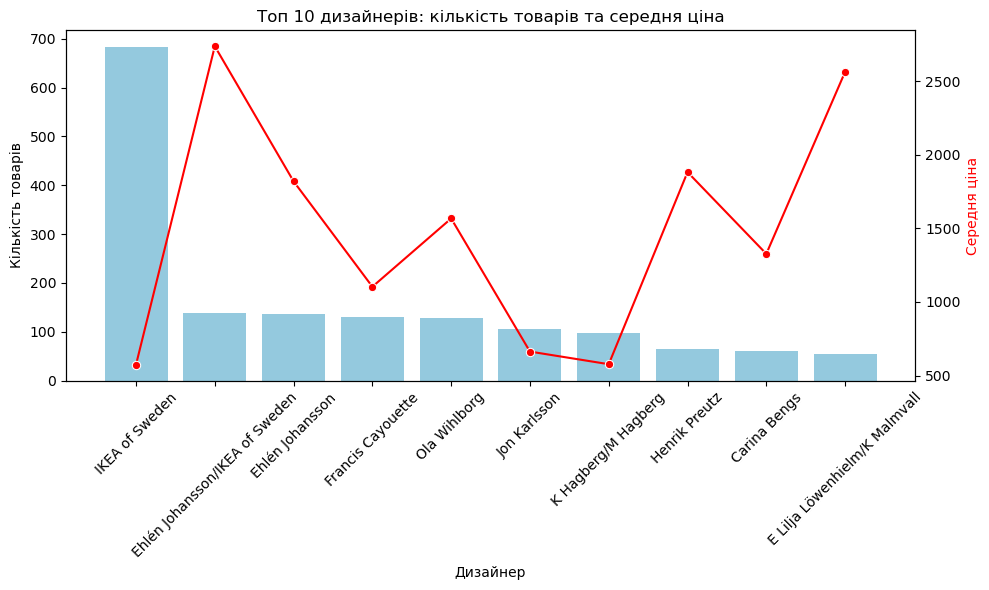

In [16]:
designer_stats = df.groupby('designer').agg({
    'item_id': 'count',
    'final_price': 'mean'
}).rename(columns={'item_id': 'count', 'final_price': 'avg_price'})
top_designers = designer_stats.sort_values('count', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(10,6))
sns.barplot(x=top_designers.index, y=top_designers['count'], ax=ax1, color='skyblue')

ax1.set_xlabel('Дизайнер')
ax1.set_ylabel('Кількість товарів')
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()

sns.lineplot(x=top_designers.index, y=top_designers['avg_price'], ax=ax2, color='red', marker='o')
ax2.set_ylabel('Середня ціна', color='red')

plt.title('Топ 10 дизайнерів: кількість товарів та середня ціна')
plt.tight_layout()
plt.show()

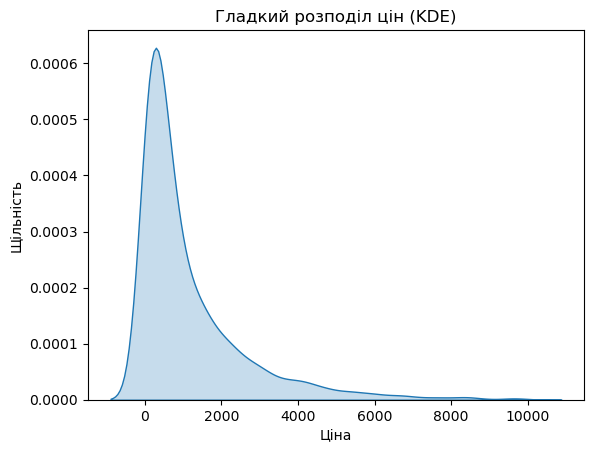

In [17]:
sns.kdeplot(df['final_price'], fill=True)
plt.title("Гладкий розподіл цін (KDE)")
plt.xlabel("Ціна")
plt.ylabel("Щільність")
plt.show()

In [18]:
def scatter_plot(df,list_fitch,target):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    for i, fitch in enumerate(list_fitch):
        sns.scatterplot(data=df, x=fitch, y=target, ax=axes[i])

        axes[i].set_title(f'{target} vs {fitch}')
        axes[i].set_xlabel(fitch)
        if i == 0:
            axes[i].set_ylabel(target)
    
    plt.tight_layout()
    plt.show()

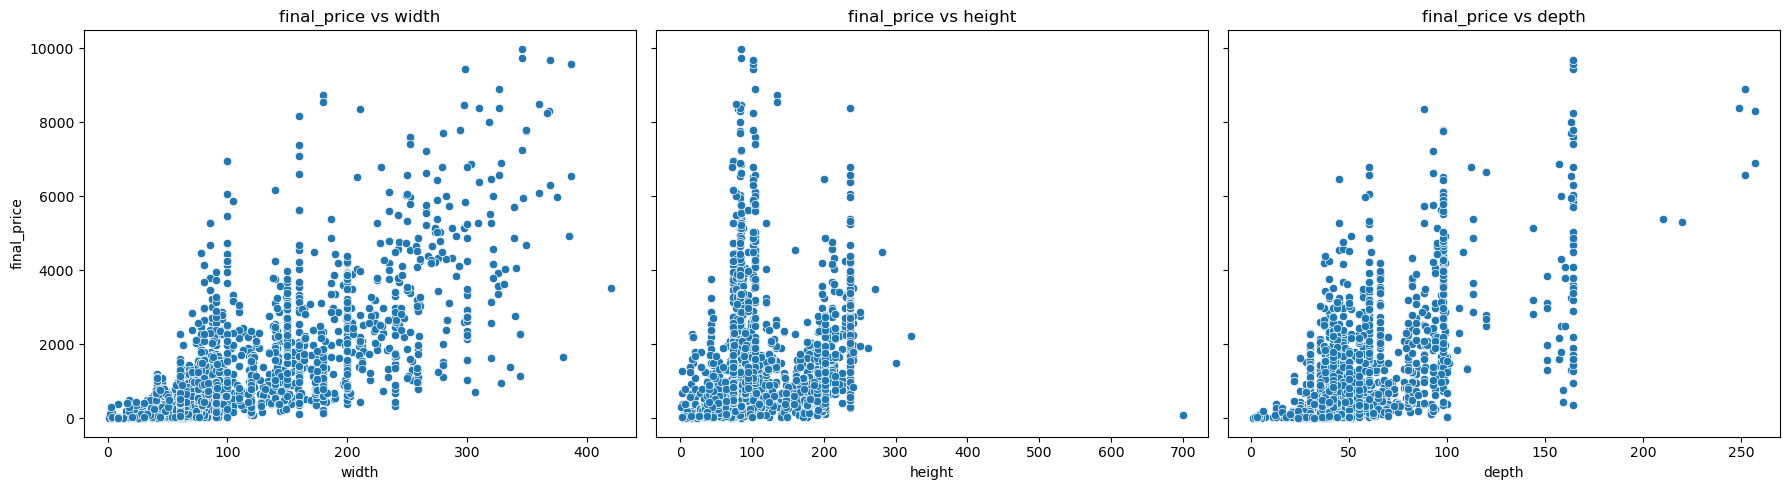

In [19]:
list_fithct = ['width','height','depth']
target = 'final_price'
scatter_plot(df,list_fithct,target)

In [20]:
high_price_df = df[df['height'] > 600]
high_price_df

,Unnamed: 0,item_id,name,category,price,old_price,sellable_online,other_colors,short_description,designer,depth,height,width,final_price
2884,2884,80278273,HILVER,Tables & desks,100.0,NaN,True,No,"Leg cone-shaped, 70 cm",Chenyi Ke,NaN,700.0,NaN,100.0


In [21]:
df.loc[df['item_id'] == 80278273, 'height'] = 70

**Замінив точково неправильну висоту в одному рядку**

In [22]:
cols = ['height', 'width', 'depth']

for col in cols:
    missing_pct = df[col].isna().mean() * 100
    print(f"Відсоток пропусків у '{col}': {missing_pct:.2f}%")

Відсоток пропусків у 'height': 24.51%
Відсоток пропусків у 'width': 14.92%
Відсоток пропусків у 'depth': 37.74%


In [23]:
for col in ['height', 'width']:
    df[col] = df.groupby('category')[col].transform(lambda x: x.fillna(x.mean()))

**Для колонок height і width взяв середнє по групі, для пропущених значень**

In [24]:
log_cols = ['price', 'height', 'width', 'depth', 'final_price']

for col in log_cols:
    df[f'log_{col}'] = np.log1p(df[col])

**Проводимо нормалізацію за допомогою логарифмування**

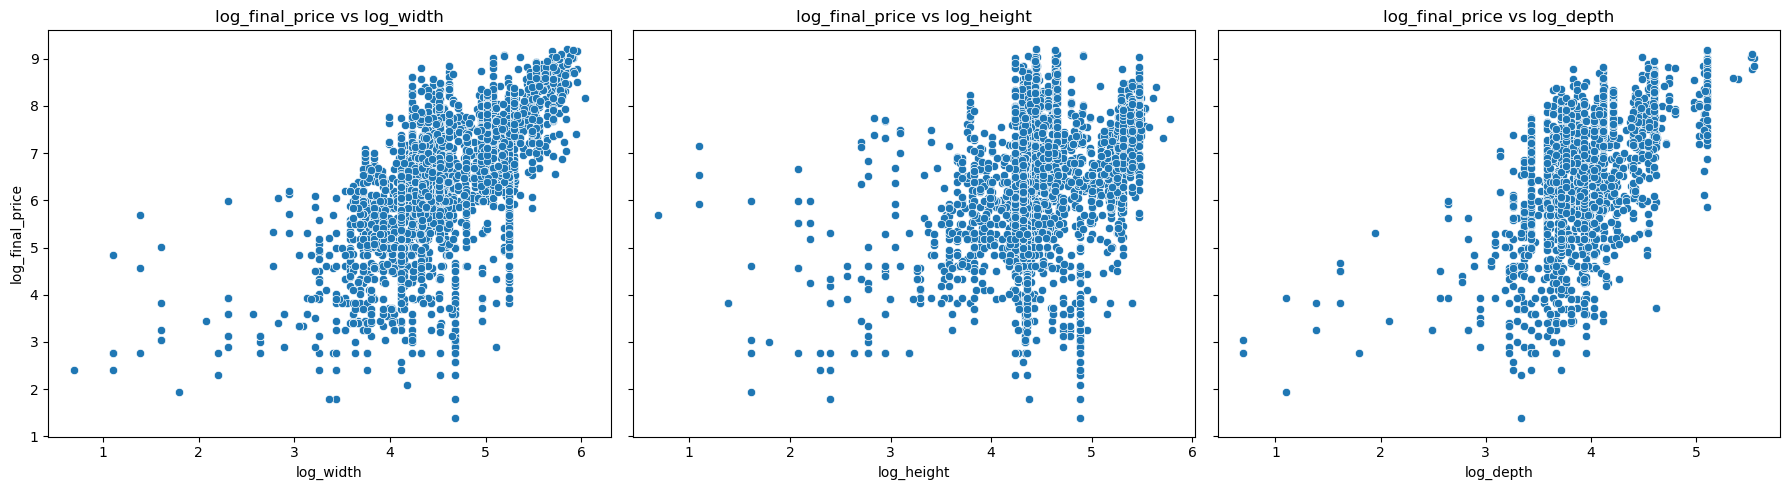

In [25]:
list_fithct = ['log_width','log_height','log_depth']
target = 'log_final_price'
scatter_plot(df,list_fithct,target)

**Гіпотеза 1: Дизайнерські роботи стоять більше чим не дизайнерьскі**

In [26]:
designer_items = df[df['designer'] != 'IKEA of Sweden']
non_designer_items = df[df['designer'] == 'IKEA of Sweden']

print(f"З дизайнером: {len(designer_items)}")
print(f"Без дизайнера або базовий: {len(non_designer_items)}")
print("Середня ціна (дизайнер):", designer_items['final_price'].mean())
print("Середня ціна (звичайні):", non_designer_items['final_price'].mean())

З дизайнером: 2279
Без дизайнера або базовий: 683
Середня ціна (дизайнер): 1337.3457656867047
Середня ціна (звичайні): 574.0131771595901


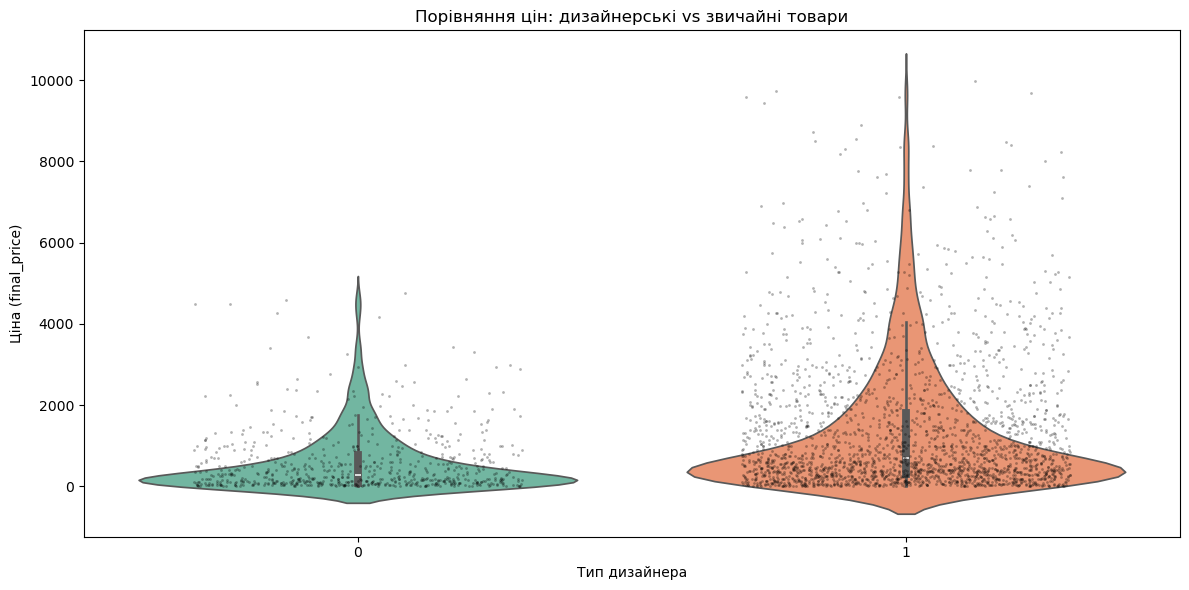

In [27]:
df['is_designer'] = df['designer'].apply(lambda x: 0 if x == 'IKEA of Sweden' else 1)

plt.figure(figsize=(12, 6))

sns.violinplot(data=df, x='is_designer', y='final_price', hue='is_designer',
               inner='box', palette='Set2', legend=False)

sns.stripplot(data=df, x='is_designer', y='final_price',
              color='black', size=2, jitter=0.3, alpha=0.3)

plt.title('Порівняння цін: дизайнерські vs звичайні товари')
plt.xlabel('Тип дизайнера')
plt.ylabel('Ціна (final_price)')
plt.tight_layout()
plt.show()

In [28]:
t_stat, p_value = ttest_ind(
    designer_items['final_price'],
    non_designer_items['final_price'],
    equal_var=False
)

print(f"T-статистика: {t_stat:.3f}")
print(f"P-value: {p_value:.4f}")

T-статистика: 17.382
P-value: 0.0000


**Гіпотеза 2: Товари з більшою кількістю варіантів кольору (other_colors не порожня) мають вищу середню ціну, ніж товари без альтернативних кольорів.**

Середня ціна (з варіантами кольору): 1320.2852830188679
Середня ціна (без варіантів кольору): 1032.6719609040929
Levene test p-value (рівність дисперсій): 0.0000
T-тест: t=5.222, p=0.0000
Манна-Уїтні тест: U=1232643.5, p=0.0000


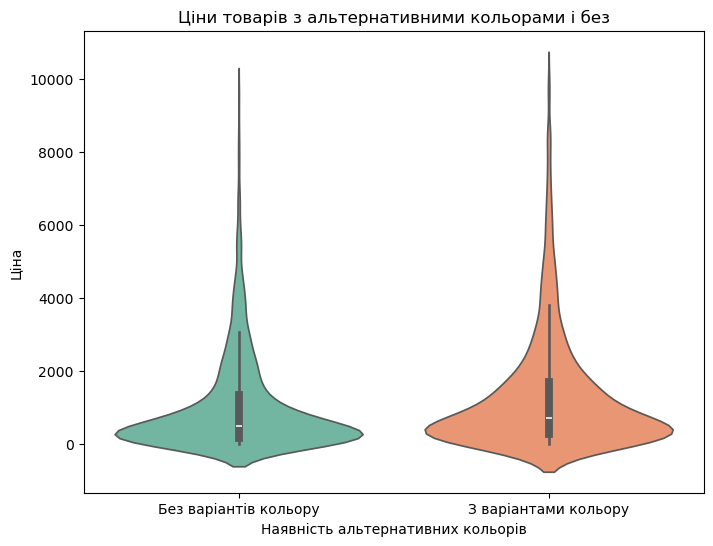

In [29]:
df['has_other_colors'] = df['other_colors'].apply(lambda x: True if x == 'Yes' else False)
with_colors = df[df['has_other_colors'] == True]['final_price']
without_colors = df[df['has_other_colors'] == False]['final_price']

print("Середня ціна (з варіантами кольору):", with_colors.mean())
print("Середня ціна (без варіантів кольору):", without_colors.mean())

stat_levene, p_levene = levene(with_colors, without_colors)
print(f"Levene test p-value (рівність дисперсій): {p_levene:.4f}")

t_stat, p_value = ttest_ind(with_colors, without_colors, equal_var=(p_levene > 0.05))
print(f"T-тест: t={t_stat:.3f}, p={p_value:.4f}")

u_stat, p_mannwhitney = mannwhitneyu(with_colors, without_colors, alternative='two-sided')
print(f"Манна-Уїтні тест: U={u_stat}, p={p_mannwhitney:.4f}")

plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x='has_other_colors', y='final_price', hue='has_other_colors', palette='Set2', legend=False)
plt.xlabel('Наявність альтернативних кольорів')
plt.ylabel('Ціна')
plt.title('Ціни товарів з альтернативними кольорами і без')
plt.xticks([0, 1], ['Без варіантів кольору', 'З варіантами кольору'])
plt.show()

**Гіпотеза підтверджується — товари з альтернативними кольорами мають значно вищу ціну, ніж ті, що без них.**

**Далі ми робимо на колонці short_description кластеризація, бо було помічено що вони можуть містити ширші данні чим Категорія і допоможе моделі більш якісно класифікувати товар і визначати його ціну**


In [30]:
df['desc_first_part'] = df['short_description'].apply(lambda x: x.split(',')[0].lower())
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = [w for w in text.split() if w not in stop_words]
    return ' '.join(words)

df['desc_clean'] = df['desc_first_part'].apply(clean_text)

In [31]:
vectorizer = TfidfVectorizer(max_features=500)
X = vectorizer.fit_transform(df['desc_clean'])
num_clusters = 15 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X)
df['desc_cluster'] = clusters

In [32]:
for cluster_num in sorted(df['desc_cluster'].unique()):
    print(f"\n=== Кластер {cluster_num} ===")

    top_desc = df[df['desc_cluster'] == cluster_num]['desc_first_part'].value_counts().head(10)
    print("Топ описів:")
    print(top_desc)

    category_counts = df[df['desc_cluster'] == cluster_num]['category'].value_counts()
    print("\nКатегорії в кластері:")
    print(category_counts)


=== Кластер 0 ===
Топ описів:
desc_first_part
desk                        25
children's desk chair        6
desk sit/stand               6
desk combination             4
desk with screen             4
desk with add-on unit        3
desk top                     2
reception desk sit/stand     2
desk with shelf unit         2
screen for desk              2
Name: count, dtype: int64

Категорії в кластері:
category
Tables & desks                48
Children's furniture          11
Chairs                         7
Bookcases & shelving units     3
Beds                           2
Room dividers                  1
Name: count, dtype: int64

=== Кластер 1 ===
Топ описів:
desc_first_part
wardrobe                           122
wardrobe combination                29
corner wardrobe                     12
open wardrobe                        4
wardrobe with 2 doors                3
wardrobe with 2 doors+3 drawers      3
wardrobe with 3 doors                3
wardrobe with 9 doors                2
wa

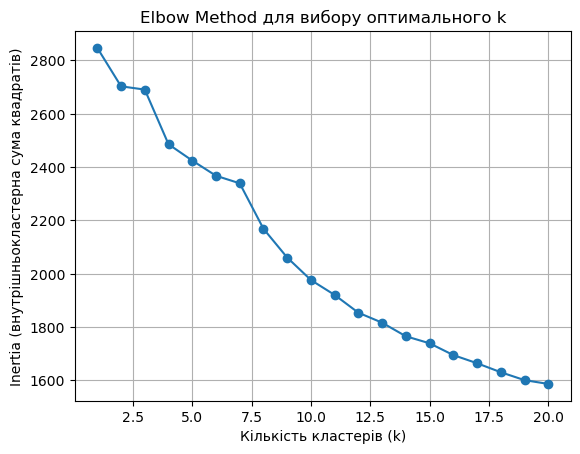

In [33]:
inertias = []
k_range = range(1, 21)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

plt.plot(k_range, inertias, marker='o')
plt.xlabel('Кількість кластерів (k)')
plt.ylabel('Inertia (внутрішньокластерна сума квадратів)')
plt.title('Elbow Method для вибору оптимального k')
plt.grid(True)
plt.show()

**Використав Elbow Method для перевірки вибору оптимального k, але все таки зупинився на 15, мені так більше подобається а результат майже не змінюється**

**Замінив для в глибині всі NA на -1, бо вважаю не правильним його заміняти на середне а краще замінити на окремо інтове унікальне значення. В depthp найбільше пропусків і їм можна розуміти по різному, бо не всі меблі мають таку міру** 

In [34]:
df['log_depth'] = df['log_depth'].fillna(-1)

In [35]:
exclude_cols = ['Unnamed: 0','item_id', 'old_price', 'price'
                ,'final_price','depth','height','width'
                ,'desc_first_part','other_colors','log_price'
                ,'log_final_price','short_description','desc_first_part'] 
X = df.drop(exclude_cols, axis=1)
y = df['log_final_price']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2962 entries, 0 to 3692
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              2962 non-null   object 
 1   category          2962 non-null   object 
 2   sellable_online   2962 non-null   bool   
 3   designer          2962 non-null   object 
 4   log_height        2962 non-null   float64
 5   log_width         2962 non-null   float64
 6   log_depth         2962 non-null   float64
 7   is_designer       2962 non-null   int64  
 8   has_other_colors  2962 non-null   bool   
 9   desc_clean        2962 non-null   object 
 10  desc_cluster      2962 non-null   int32  
dtypes: bool(2), float64(3), int32(1), int64(1), object(4)
memory usage: 225.6+ KB


In [38]:
cat_cols = ['name', 'sellable_online', 'category', 'designer','has_other_colors','desc_clean']
num_cols = ['log_height', 'log_width', 'log_depth', 'is_designer','desc_cluster']

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cat_cols)
], remainder='passthrough')  # числові — як є

models = {
    'LinearRegression': LinearRegression(),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'RandomForestRegressor':RandomForestRegressor(n_estimators=100,random_state=42)
}

results = {}

for name, reg in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', reg)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    results[name] = {
        'R2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': root_mean_squared_error(y_test, y_pred)
    }


for name, metrics in results.items():
    print(f'\n{name}:')
    for metric, value in metrics.items():
        print(f'{metric}: {value:.3f}')


LinearRegression:
R2: 0.880
MAE: 0.323
RMSE: 0.482

GradientBoosting:
R2: 0.775
MAE: 0.524
RMSE: 0.660

XGBoost:
R2: 0.856
MAE: 0.400
RMSE: 0.528

RandomForestRegressor:
R2: 0.860
MAE: 0.371
RMSE: 0.521


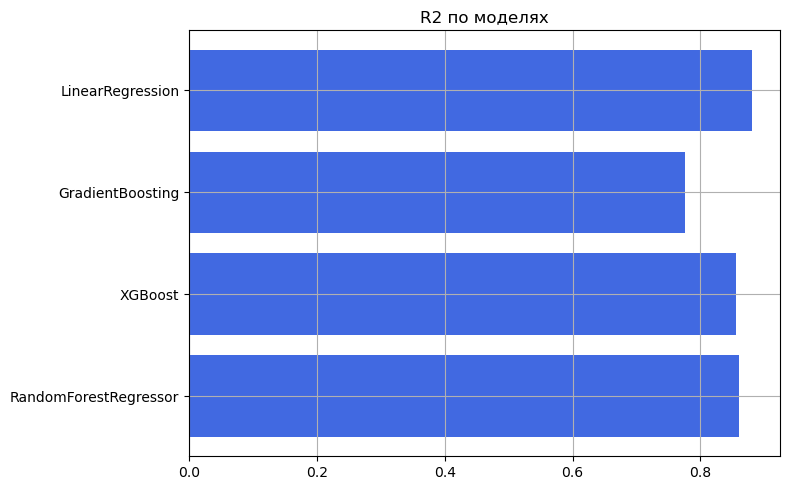

In [39]:
model_names = list(results.keys())
R2 = [metrics['R2'] for metrics in results.values()]

plt.figure(figsize=(8, 5))
plt.barh(model_names, R2, color='royalblue')
plt.title('R2 по моделях')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
cat_cols = ['name', 'sellable_online', 'category', 'designer','has_other_colors','desc_clean']
num_cols = ['log_height', 'log_width', 'log_depth', 'is_designer','desc_cluster']

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cat_cols)
], remainder='passthrough')


model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


model.fit(X_train, y_train)


y_pred = model.predict(X_test)


print('R^2:', r2_score(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('RMSE:', root_mean_squared_error(y_test, y_pred))


y_pred_orig = np.exp(y_pred)
y_test_orig = np.exp(y_test)

print('\nОригінальні одиниці (після експоненти):')
print('R^2 :', r2_score(y_test_orig, y_pred_orig))
print('MAE :', mean_absolute_error(y_test_orig, y_pred_orig))
print('RMSE :', root_mean_squared_error(y_test_orig, y_pred_orig))

R^2: 0.8803536300735719
MAE: 0.3232235177159691
RMSE: 0.48170225987688564

Оригінальні одиниці (після експоненти):
R^2 : 0.8146674811872086
MAE : 313.0691944388006
RMSE : 635.1643956790284


**Найкраще справляється зі задачею LinearRegression**

**Спробуємо підбрати гіпер параметри для RandomForestRegressor, бо для лінійної особливо їх не підбереш**

In [47]:
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cat_cols)
], remainder='passthrough')

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid = {
    'regressor__n_estimators': [100,150,200,250],
    'regressor__max_depth': [10, 15, 20, 25,50],
    'regressor__min_samples_split': [2,3,5,8],
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print("Найкращі параметри:", grid_search.best_params_)

y_pred = best_model.predict(X_test)

print('R^2 :', r2_score(y_test, y_pred))
print('MAE :', mean_absolute_error(y_test, y_pred))
print('RMSE :', root_mean_squared_error(y_test, y_pred))

y_pred_orig = np.exp(y_pred)
y_test_orig = np.exp(y_test)

print('Оригінальні одиниці (після експоненти):')
print('R^2 :', r2_score(y_test_orig, y_pred_orig))
print('MAE :', mean_absolute_error(y_test_orig, y_pred_orig))
print('RMSE :', root_mean_squared_error(y_test_orig, y_pred_orig))

Fitting 3 folds for each of 80 candidates, totalling 240 fits
Найкращі параметри: {'regressor__max_depth': 50, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 250}
R^2 : 0.860304758599791
MAE : 0.3687372396461229
RMSE : 0.5204987929522529
Оригінальні одиниці (після експоненти):
R^2 : 0.8481035491373476
MAE : 316.2738900651299
RMSE : 575.0215814589474
